In [1]:
import pickle
from tqdm import tqdm

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Trace builiding code
class Trace:
    def __init__(self):
        self.calls = []

class Node_info:
    def __init__(self, num_id, n_type):
        self.num_id = num_id
        self.n_type = n_type

class Call:
    def __init__(self, traceid, timestamp, rpcid, um, dm, rpctype, interface, rt):
        self.traceid = traceid
        self.timestamp = timestamp
        self.rpcid = rpcid
        self.um = um
        self.dm = dm 
        self.rpctype = rpctype
        self.interface = interface
        self.rt = rt
    def string(self):
        return self.traceid + "," + str(self.timestamp) + "," + self.rpcid + "," + self.um + "," + self.dm + "," +\
            self.rpctype + "," + self.interface + "," + str(self.rt)

def csv_to_df(file: str):
    use_columns = list(range(9)) 
    df = pd.read_csv(file,delimiter=',', usecols=use_columns)
    return df

def extract_traceid_rows(df, tid):
    f_df = df[df['traceid'] == tid]
    tid_calls = [
        Call(
            str(row.traceid), 
            int(row.timestamp), 
            str(row.rpcid), 
            str(row.um), 
            str(row.dm), 
            str(row.rpctype), 
            str(row.interface), 
            int(row.rt)
        ) for row in f_df.itertuples(index=False)
    ]
    return tid_calls


def df_to_tracesdict(df):
    '''
    Args: Alibaba traces dataframe
    Return: Dict, Key:tid, Val:list of edges
    '''
    tids_list = df['traceid'].unique().tolist()
    traces_edges = {}
    for i in tqdm(range(len(tids_list))):
        tid_calls = extract_traceid_rows(df, tids_list[i])
        t_edges = [] # list of edges of trace
        for call in tid_calls:
            t_edges.append([call.um, call.dm])
        traces_edges[tids_list[i]] = t_edges
    return traces_edges

def df_rpcid_analysis(df):
    tids_list = df['traceid'].unique().tolist()
    no_inode_tids = []
    no_inode_tid_rpcid = {}
    for i in tqdm(range(len(tids_list))):
        tid_calls = extract_traceid_rows(df, tids_list[i])
        initial_node = ''
        for call in tid_calls:
            if call.rpcid == "0":
                initial_node = call.dm
        if initial_node == '':
            no_inode_tids.append(tids_list[i])
    for i in tqdm(range(len(no_inode_tids))):
        tid_calls = extract_traceid_rows(df, no_inode_tids[i])
        for call in tid_calls:
            if no_inode_tids[i] not in no_inode_tid_rpcid:
                no_inode_tid_rpcid[no_inode_tids[i]] = []
            no_inode_tid_rpcid[no_inode_tids[i]].append(call.rpcid)

    return no_inode_tid_rpcid

def build_digraph_from_tracesdict(traces_dict):

    full_graph_edge_list = []
    for edge_list in traces_dict.values():
        full_graph_edge_list.extend(edge_list)
    G = nx.DiGraph()
    G.add_edges_from(full_graph_edge_list)

    return G

def pkl_to_dict(file_path):
    with open(file_path, 'rb') as pkl_file:
        T_prime = pickle.load(pkl_file)
    return T_prime

def pkl_to_graph(exp_name):
    file_path = 'downsampled_graphs/' + exp_name + '.pkl'
    T_prime = pkl_to_dict(file_path)
    sampled_G = build_digraph_from_tracesdict(T_prime)

    return sampled_G

In [3]:
'''
Read & Build Original Graph
'''
df = csv_to_df("./casper_rebuild_cleaned.csv")

# Extract all tids
tids_list = df['traceid'].unique()
num_traces = len(tids_list)
print("Num of tids: ", num_traces)

# Building the full original digraph
T_original = df_to_tracesdict(df)
G_original = build_digraph_from_tracesdict(T_original)

print("Number of nodes:", G_original.number_of_nodes())

Num of tids:  8937


100%|██████████| 8937/8937 [02:39<00:00, 55.95it/s]


Number of nodes: 3987


In [10]:
'''
Read & Build Sampled graphs
'''
T_prime_500n_4500t = pkl_to_dict('downsampled_graphs/500nodes_4500traces.pkl')
T_prime_300n_4500t = pkl_to_dict('downsampled_graphs/300nodes_4500traces.pkl')

# Building the sampled original digraph
G_sampled_500 = build_digraph_from_tracesdict(T_prime_500n_4500t)
G_sampled_300 = build_digraph_from_tracesdict(T_prime_300n_4500t)

print("Number of nodes:", G_sampled_500.number_of_nodes())
print("Number of nodes:", G_sampled_300.number_of_nodes())


Number of nodes: 481
Number of nodes: 300


In [27]:
'''
In & Out degree distribution
'''
def in_out_deg_dist_viz_cdf(Gs_and_labels, fig_name, plot_title):
    '''
    Generates a CDF graph for in and out deg dist of graphs
    Args: Gs_and_label= [[G, label], [], ...],
          in_or_out= 'in' or 'out'
    '''
    for G, label in Gs_and_labels:
        # get deg dist
        in_degrees = G.in_degree(G.nodes())
        out_degrees = G.out_degree(G.nodes())
        indeg_dist = np.sort([tup[1] for tup in list(in_degrees)])
        outdeg_dist = np.sort([tup[1] for tup in list(out_degrees)])
        
        in_y_vals = np.arange(len(indeg_dist))/float(len(indeg_dist))
        out_y_vals = np.arange(len(outdeg_dist))/float(len(outdeg_dist))
        plt.plot(indeg_dist, in_y_vals, label=f"{label} (In-degree)")
        plt.plot(outdeg_dist, out_y_vals, label=f"{label} (Out-degree)", linestyle='--')

    plt.xlabel('Degree')
    plt.xscale('log')
    plt.ylabel('CDF')
    plt.title(plot_title)
    plt.legend()
    plt.tight_layout()
    # plt.show()

    plt.savefig(f"figs/{fig_name}.png")
    plt.close()

def deg_dist_viz_cdf(Gs_and_labels, in_or_out, fig_name):
    '''
    Generates a CDF graph for in/out deg dist of graphs
    Args: Gs_and_label= [[G, label], [], ...],
          in_or_out= 'in' or 'out'
    '''
    for G, label in Gs_and_labels:
        if in_or_out == 'in':
            degrees = G.in_degree(G.nodes())
        elif in_or_out == 'out':
            degrees = G.out_degree(G.nodes())
        deg_dist = [tup[1] for tup in list(degrees)]
        x_vals = np.sort(deg_dist)
        y_vals = np.arange(len(deg_dist))/float(len(deg_dist))
        plt.plot(x_vals, y_vals, label=label)
    if in_or_out == "in":
        plt.xlabel('In-degree')
    if in_or_out == "out":
        plt.xlabel('Out-degree')
    plt.xscale('log')
    plt.ylabel('CDF')
    plt.legend()
    plt.tight_layout()
    # plt.show()

    plt.savefig(f"figs/{fig_name}.png")
    plt.close()
# Kolmogrov D Statistic

def deg_dist_viz_hist(Gs_and_labels, in_or_out):
    '''
    Generates a histogram for in/out deg dist of graphs
    Args: Gs_and_label= [[G, label], [], ...],
          in_or_out= 'in' or 'out'
    '''
    for G, label in Gs_and_labels:
        if in_or_out == 'in':
            degrees = G.in_degree(G.nodes())
        elif in_or_out == 'out':
            degrees = G.out_degree(G.nodes())
        deg_dist = [tup[1] for tup in list(degrees)]
        plt.hist(deg_dist,alpha=0.4, label=label)#bins=range(min(deg_dist), max(deg_dist) + 1)
    if in_or_out == "in":
        plt.xlabel('In-degree')
    elif in_or_out == "out":
        plt.xlabel('Out-degree')
        
    plt.ylabel('Frequency')
    plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    plt.show()

import numpy as np
from scipy.special import rel_entr

def calc_ks_stat():
    pass

In [ ]:
Original_indeg_dist = [tup[1] for tup in list(G_original.in_degree(G_original.nodes()))]
Original_outdeg_dist = [tup[1] for tup in list(G_original.out_degree(G_original.nodes()))]

In [29]:
'''
Experiment for Downscaling Impact
'''

Gs_and_labels = [[G_original, 'Original Graph(4000n:9000t)'],\
                 [G_sampled_500, '(8x)Sampled Graph(500n:4500t)'],\
                 [G_sampled_300, '(13x)Sampled Graph(300n:4500t)']
                 ]
deg_dist_viz_cdf(Gs_and_labels, 'in',\
                  'node_dscaling_impact/indeg_dist_dscale_4.5kt')
deg_dist_viz_cdf(Gs_and_labels, 'out',\
                  'node_dscaling_impact/outdeg_dist_dscale_4.5kt')
in_out_deg_dist_viz_cdf(Gs_and_labels, \
                'node_dscaling_impact/inoutdeg_dist_dscale_4.5kt',\
                'Node Downscaling Impact')

In [30]:
'''
Experiment for Comparing impact of t' on in/out deg distributions
'''

G_300n_4500t = pkl_to_graph('300nodes_4500traces')
G_300n_2250t = pkl_to_graph('300nodes_2250traces')


Gs_and_labels = [[G_original, 'Original Graph(3655n:10421t)'],[G_300n_4500t, '(13x)Sampled Graph(300n:4500t)'], \
                 [G_300n_2250t, '(13x)Sampled Graph(300n:2250t)']]

in_out_deg_dist_viz_cdf(Gs_and_labels, \
                'num_traces_impact/inoutdeg_dist_timpact_4.5kt',\
                'Num traces Impact')

In [14]:
'''
Call depth percentage distribution
'''
def calc_graph_depth(G, initial_node):
    def dfs(node, visited, stack):
        # Using stack to avoid cycles
        if node in stack:
            return 0
        
        if node in visited:
            return visited[node]
        
        stack.add(node)
        max_depth = 0

        for neighbour in G.successors(node):
            depth = dfs(neighbour, visited, stack)
            max_depth = max(max_depth, depth)

        stack.remove(node)

        visited[node] = max_depth + 1
        
        return visited[node]
    
    visited = {}
    stack = set()

    return dfs(initial_node, visited, stack)


def find_depth(G, initial_node):
    # Calculate shortest path lengths from the initial node to all reachable nodes
    path_lengths = nx.single_source_shortest_path_length(G, source=initial_node)
    
    # Find the maximum path length (i.e., the depth of the graph)
    longest_path_length = max(path_lengths.values(), default=0)
    return longest_path_length


# T_original
T_details = pkl_to_dict('downsampled_graphs/trace_details_data.pkl')
cd_count_dict = {}
traces_count = 0
check = []
for tid, t_edges in T_original.items():
    traces_count += 1
    G = nx.DiGraph()
    G.add_edges_from(t_edges)
    t_ini_node = T_details[tid][2]
    trace_depth = find_depth(G, t_ini_node)
    if trace_depth not in cd_count_dict:
        cd_count_dict[trace_depth] = 1
    else:
        cd_count_dict[trace_depth] += 1
    if trace_depth == 0:
        check.append(tid)
print(traces_count)
cd_percent_arr = []
for cd in cd_count_dict:
    percent_t_cd = 100 * cd_count_dict[cd]/traces_count
    cd_percent_arr.append([cd, percent_t_cd])

cd_percent_arr.sort(key=lambda x: x[0])
print(cd_percent_arr)
print(check)

8937
[[0, 49.31184961396442], [1, 47.28656148595726], [2, 0.3804408638245496], [3, 0.7385028533064787], [4, 1.107754279959718], [5, 0.1902204319122748], [6, 0.4140091753384805], [7, 0.3021148036253776], [8, 0.14546268322703368], [9, 0.11189437171310283], [10, 0.011189437171310284]]
['0b1339ef15919536802818000ea36a', '0b14283415919538357369000ef8da', '0b14104315919538740923000efbfc', '0b133a9a15919537146067000ebe21', '0b5218e015919536338052000eaedf', '0b14325915919538125733000e3f6e', '0b52066615919536502072000e4c32', '0b1431b715919538874979000e6098', '0b51187915919536490224000e46a4', '0b52063615919537852871000e8d14', '0b14315f15919536920878000e3e79', '0b133a5f15919476475677000e76ea', '0b5206cd15919476536496000eabe9', '0b5118c915919476975793000e208f', '0b51172415919476203349000e43eb', '0b5218cf15919478479125000e5f45', '0b5118db15919478855953000e870a', '0b5218ce15919478636586000e2b2d', '0b5117dc15919477216325000e156a', '0b13393115919478284477000ef48f', '0b14400315919478359294000e24c1', '0

100.00000000000001


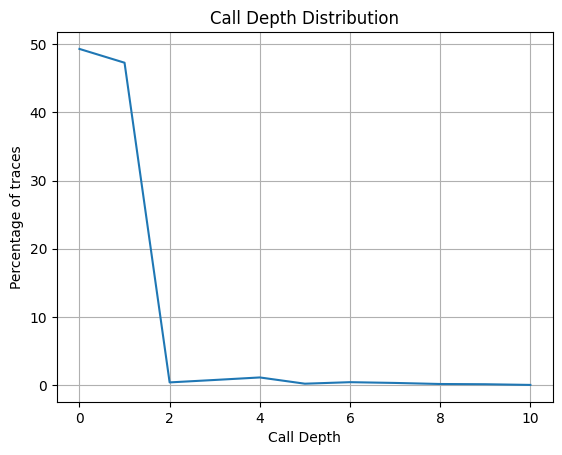

In [8]:
res= 0
for i in cd_percent_arr:
    res += i[1]
print(res)
valid_cds = [x[0] for x in cd_percent_arr]
cd_percentages = [x[1] for x in cd_percent_arr]
plt.plot(valid_cds, cd_percentages)
plt.grid(True)
plt.xlabel('Call Depth')
plt.ylabel('Percentage of traces')
plt.title('Call Depth Distribution')
# plt.savefig('figs/cd_distribution_from_rpcids.png')
plt.show()

In [23]:
problem_traces = ['0b1339ef15919536802818000ea36a', '0b14283415919538357369000ef8da',\
  '0b14104315919538740923000efbfc', '0b133a9a15919537146067000ebe21',\
'0b5218e015919536338052000eaedf', '0b14325915919538125733000e3f6e',\
'0b52066615919536502072000e4c32', '0b1431b715919538874979000e6098',\
'0b51187915919536490224000e46a4', '0b52063615919537852871000e8d14',\
'0b14315f15919536920878000e3e79', '0b133a5f15919476475677000e76ea']

def plot_graph_simple(graph, filename, special_node=None):
    plt.figure(figsize=(8, 6))  # Adjust figure size as needed
    
    # Generate positions for nodes
    pos = nx.spring_layout(graph)
    
    # Default node color
    node_colors = ['lightblue' if node != special_node else 'orange' for node in graph.nodes]
    
    # Draw the graph
    nx.draw(graph, pos, with_labels=False, node_color=node_colors, edge_color='black')
    
    # Save the figure with high quality
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

tid = problem_traces[2]
t_edges = T_original[tid]
t_ini_node = T_details[tid][2]
G = nx.DiGraph()
G.add_edges_from(t_edges)
plot_graph_simple(G, 'test.png', t_ini_node)

In [42]:
'''
Sfsl ratio
'''
node_details_dict = pkl_to_dict('downsampled_graphs/node_details_data.pkl')

def calc_sfsl_ratio(G, node_details_dict):
    '''
    Args: node_details_dict= Key: Nodeid, Val: type
    Returns: sfsl ratio
    '''
    sf_ctr = 0
    sl_ctr = 0
    num_nodes = len(G_original.nodes())
    for node in G_original.nodes():
        if node in node_details_dict and node_details_dict[node][1] == 'db':
            sf_ctr += 1
        else:
            sl_ctr += 1
    sfsl_ratio = sf_ctr/sl_ctr
    print("Total nodes: ", num_nodes)
    print("sfsl ratio: ", sfsl_ratio)
    print("Sf percent: ", (sf_ctr/num_nodes)*100)
    print("Sl percent: ", (sl_ctr/num_nodes)*100)
    return sfsl_ratio

calc_sfsl_ratio(G, node_details_dict)

Total nodes:  3987
sfsl ratio:  1.4061557030778515
Sf percent:  58.439929771758216
Sl percent:  41.560070228241784


1.4061557030778515

In [41]:
'''
KSDS experiment
Args: G_eval_info= [[indeg_dist, outdeg_dist, call_depth_dist,
        G_label],...]
'''






'\nKSDS experiment\n'